# k-Nearest Neighbors (kNN)
Student Name: Nojus Satikauskas      
Student Number: C00261186    
Module: Data Science and Machine Learning 2 - Y4

Business Understanding
Objective:

The objective of this project is to summarize the pros and cons of the k-Nearest Neighbors algorithm and provide two Python examples for classification and regression tasks.

Data Set:    
(https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) 
(https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)        

Theory
* Is a non-probabilistic, non-parametric, and instance-based learning algorithm.
    * **Non-parametric**: Makes no explicit assumptions about the function form of _h_.
    * **Instance-based**: Does not explicitly learn a model but memorizes training instances.

Pros
* Simple to understand and implement.
* Little to zero training time.
* Works easily with multi-class data sets.
* Effective in scenarios with highly unusual data distributions.

Cons
* Computationally expensive testing phase.
* Suffers from skewed class distributions.
* Accuracy can degrade with high-dimensional data due to the curse of dimensionality.

References
* Wikipedia: [kNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)
* Scikit-learn: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
* [Complete Guide to K-Nearest-Neighbors](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor)

## Classification
* The output is a class membership.
* An object is classified by a majority vote of its neighbors.



## Wine Quality Analysis

In this project, we will analyze a dataset containing various attributes of wine samples, such as fixed acidity, volatile acidity, citric acid, and more. The goal is to predict the quality of wine based on these attributes.

### Dataset Description

The dataset contains the following attributes:

- **Fixed Acidity**: The non-volatile acids in wine.
- **Volatile Acidity**: The amount of acetic acid in wine, which leads to an unpleasant vinegar taste.
- **Citric Acid**: Found in small quantities, citric acid can add 'freshness' and flavor to wines.
- **Residual Sugar**: The amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.
- **Chlorides**: The amount of salt in the wine.
- **Free Sulfur Dioxide**: The free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.
- **Total Sulfur Dioxide**: Amount of free and bound forms of SO2; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.
- **Density**: The density of wine is close to that of water depending on the percent alcohol and sugar content.
- **pH**: Describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.
- **Sulphates**: Additives that contribute to SO2 levels, which act as antimicrobial and antioxidant agents.
- **Alcohol**: The percent alcohol content of the wine.
- **Quality**: The quality of the wine rated on a scale from 0 to 10.

Let's start by loading the dataset and performing some exploratory data analysis.

### Code Implementation

## Data Preprocessing

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Importing necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_csv("winequality-red.csv")

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Basic statistics of the dataset
print("\nBasic statistics of the dataset:")
print(df.describe())

# Checking for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())


First few rows of the dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8 

### Check for missing values

In [62]:
print("\nHandling missing values:")
print(df.isnull().sum())


Handling missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


### Impute missing values (if any)

In [63]:
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(df)

### Split data 

In [64]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

X = scaled_data[:, :-1]  # Features
y = scaled_data[:, -1]   # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Instantiate the KNN Classifier

In [65]:
from sklearn.neighbors import KNeighborsClassifier

# Specify the number of neighbors (k)
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)


## Model Training

In [66]:
# Convert target variable to categorical labels
df['quality'] = pd.cut(df['quality'], bins=[0, 5, 7, 10], labels=['Low', 'Medium', 'High'])

# Split the Data
X = df.drop(columns=['quality'])  # Features
y = df['quality']                  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

# Specify the number of neighbors (k)
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Model Training
knn_classifier.fit(X_train, y_train)


KNeighborsClassifier()

## Model Evaluation

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
df = pd.read_csv('winequality-red.csv')

# Convert target variable to categorical labels
bins = [0, 5, 7, 10]
labels = ['Low', 'Medium', 'High']
df['quality'] = pd.cut(df['quality'], bins=bins, labels=labels)

# Split the Data
X = df.drop(columns=['quality'])  # Features
y = df['quality']                  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the KNN Classifier
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Model Training
knn_classifier.fit(X_train_scaled, y_train)

# Model Evaluation
y_pred = knn_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



Model Evaluation:
Accuracy: 0.68125
Precision: 0.673769435351882
Recall: 0.68125
F1 Score: 0.6764533342847241


# Regression 
house prices

**Loading the Dataset**
First, we need to load the dataset into a suitable data structure for analysis. Typically, we'll use a DataFrame provided by a library like Pandas in Python.

In [68]:
import pandas as pd

# Load the dataset
data = pd.read_csv("Housing.csv")

# Display the first few rows of the dataset to understand its structure
print(data.head())


      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


**Exploring the Dataset**
After loading the dataset, we'll explore its structure, dimensions, and summary statistics to gain insights into the data.

In [69]:
# Check the dimensions of the dataset
print("Dimensions of the dataset:", data.shape)

# Display summary statistics of numerical variables
print("Summary statistics:\n", data.describe())

# Check for any missing values in the dataset
print("Missing values:\n", data.isnull().sum())


Dimensions of the dataset: (545, 13)
Summary statistics:
               price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

          parking  
count  545.000000  
mean     0.693578  
std      0.861586  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      3.000000  
Missing values:
 price               0
area                0
bedrooms            0
bathrooms           0

#### **Data Preprocessing**
Before performing any analysis or modeling, we may need to preprocess the data. This involves handling missing values, encoding categorical variables, and scaling numerical variables if required.

In [70]:
import pandas as pd

# Load the dataset
data = pd.read_csv("Housing.csv")

# Convert categorical variables to numerical values
data['mainroad'] = data['mainroad'].map({'yes': 1, 'no': 0})
data['guestroom'] = data['guestroom'].map({'yes': 1, 'no': 0})
data['basement'] = data['basement'].map({'yes': 1, 'no': 0})
data['hotwaterheating'] = data['hotwaterheating'].map({'yes': 1, 'no': 0})
data['airconditioning'] = data['airconditioning'].map({'yes': 1, 'no': 0})
data['prefarea'] = data['prefarea'].map({'yes': 1, 'no': 0})

# Convert 'furnishingstatus' to one-hot encoding
data = pd.get_dummies(data, columns=['furnishingstatus'], drop_first=True)

# Check for any missing values in the dataset
print("Missing values:\n", data.isnull().sum())

# There are no missing values in this dataset, so no further action is needed for handling missing values.


Missing values:
 price                              0
area                               0
bedrooms                           0
bathrooms                          0
stories                            0
mainroad                           0
guestroom                          0
basement                           0
hotwaterheating                    0
airconditioning                    0
parking                            0
prefarea                           0
furnishingstatus_semi-furnished    0
furnishingstatus_unfurnished       0
dtype: int64


### Data Analysis and Visualization

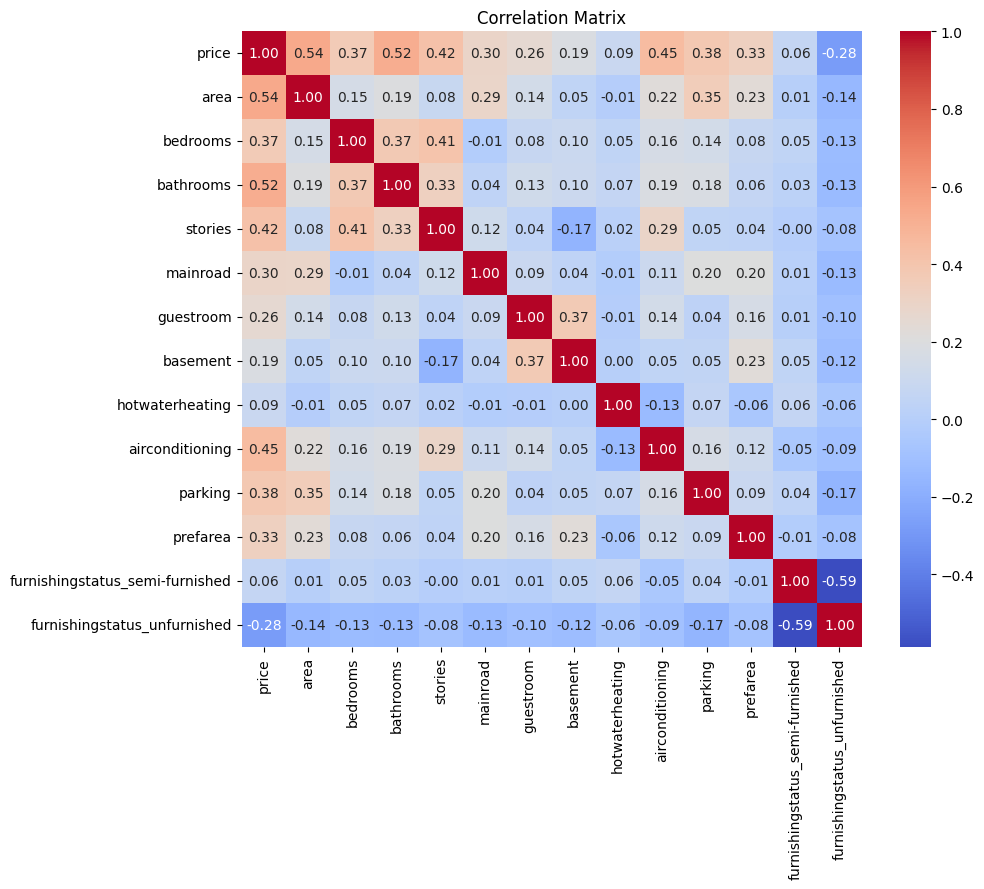

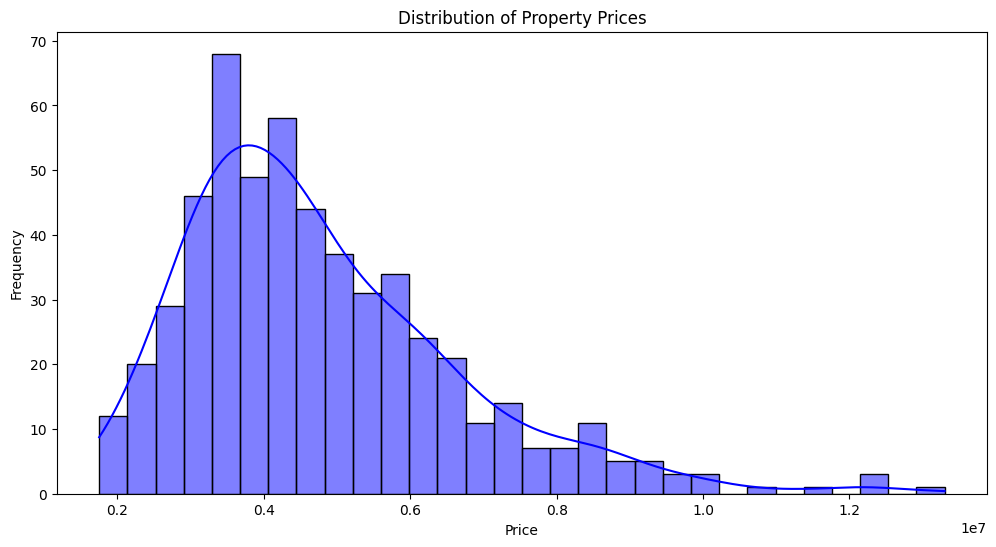

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Visualization
# For demonstration purposes, let's visualize the distribution of prices and other relevant variables.
plt.figure(figsize=(12, 6))
sns.histplot(data['price'], bins=30, kde=True, color='blue')
plt.title('Distribution of Property Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Assuming 'price' is the target variable and the rest are features
X = data.drop(columns=['price'])
y = data['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)  # Using the best parameters found earlier
knn.fit(X_train, y_train)

# Predict the prices on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

     1750000       0.00      0.00      0.00         1
     1767150       0.00      0.00      0.00         0
     1820000       0.00      0.00      0.00         1
     1855000       0.00      0.00      0.00         0
     1890000       0.00      0.00      0.00         2
     1960000       0.00      0.00      0.00         0
     2100000       0.00      0.00      0.00         1
     2135000       0.00      0.00      0.00         0
     2233000       0.00      0.00      0.00         1
     2240000       0.00      0.00      0.00         0
     2275000       1.00      1.00      1.00         1
     2310000       0.00      0.00      0.00         0
     2345000       0.00      0.00      0.00         0
     2380000       0.00      0.00      0.00         1
     2450000       0.00      0.00      0.00         2
     2520000       0.00      0.00      0.00         1
     2653000       0.00      0.00      0.00         0
    

C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: Undefi

### Building Predictive Models

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into features and target variable
X = data.drop('price', axis=1)
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and train a linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 1754318687330.6692
R-squared: 0.6529242642153174


### Conclusion and Insights

In [74]:
# Provide insights from the analysis
# For example, identify key factors influencing property prices, trends in the real estate market, etc.
# Additionally, provide actionable recommendations based on the analysis.

# For demonstration purposes, let's print the coefficients of the linear regression model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Coefficients: [ 2.35968805e+02  7.67787016e+04  1.09444479e+06  4.07476595e+05
  3.67919948e+05  2.31610037e+05  3.90251176e+05  6.84649885e+05
  7.91426736e+05  2.24841913e+05  6.29890565e+05 -1.26881818e+05
 -4.13645062e+05]
Intercept: 260032.35760741588
